In [140]:
#! pip install wurlitzer

In [240]:
# Standard stack
import datetime
import pandas as pd
import numpy as np
import re

# Visualization
from pandas_profiling import ProfileReport
#import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import tensorflow as tf
import tensorflow_decision_forests as tfdf
try:
    from wurlitzer import sys_pipes
except:
    from colabtools.googlelog import CaptureLog as sys_pipes

# Scikit-learn packages
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer

## Import helper functions
from ipynb.fs.defs.utils import *

# display
from IPython.core.magic import register_line_magic
from IPython.display import Javascript

In [156]:
KAGGLE_EVAL_METRIC = 'logloss' # string name for loss function in xgboost

In [157]:
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"

In [158]:
TARGET = ["Survived"]

# Load Data

In [181]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [182]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [183]:
## Bring in Age Predictions

In [184]:
## Creata a combined data set to ensure train + test get same pre-proccessing
train['label'] = 'train'
test['label'] = 'test'
combined = train.append(test)

# Tensorflow RandomForest

In [185]:
to_drop = ['label']

In [186]:
X = combined[combined['label'] == 'train'].drop(to_drop, axis=1)
y = combined[combined['label'] == 'train'][TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)

In [187]:
# Convert the pandas dataframe into a TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, label="Survived")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_test, label="Survived")

In [188]:
# Train the model
model_1 = tfdf.keras.RandomForestModel()
model_1.fit(train_ds)

13/13 [==============================] - 0s 999us/step


In [189]:
#Evaluate
# metric logsloss: BinaryCrossentropy
model_1.compile(metrics=["accuracy"])

with sys_pipes():
    model_1.fit(x=train_ds)

13/13 [==============================] - 0s 963us/step


In [232]:
evaluation = model_1.evaluate(test_ds, return_dict=True)

for name, value in evaluation.items():
    print(f"{name}: {value:.4f}")

2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.8222
loss: 0.0000
accuracy: 0.8222


In [192]:
# Interpreting
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0)

In [193]:
model_1.summary()

Model: "random_forest_model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (11):
	Age
	Cabin
	Embarked
	Fare
	Name
	Parch
	PassengerId
	Pclass
	Sex
	SibSp
	Ticket

No weights

Variable Importance: NUM_NODES:
    1. "PassengerId" 6854.000000 ################
    2.        "Fare" 5634.000000 ############
    3.         "Age" 4476.000000 ##########
    4.    "Embarked" 827.000000 
    5.      "Pclass" 753.000000 
    6.       "SibSp" 721.000000 
    7.       "Parch" 528.000000 
    8.      "Ticket" 496.000000 
    9.         "Sex" 480.000000 

Variable Importance: NUM_AS_ROOT:
    1.      "Sex" 167.000000 ################
    2.     "Fare" 64.000000 ######
    3.   "Pclass" 45.000000 ####
    4.   "Tick

In [194]:
model_1.make_inspector().features()

["Age" (1; #0),
 "Cabin" (4; #1),
 "Embarked" (4; #2),
 "Fare" (1; #3),
 "Name" (4; #4),
 "Parch" (1; #5),
 "PassengerId" (1; #6),
 "Pclass" (1; #7),
 "Sex" (4; #8),
 "SibSp" (1; #9),
 "Ticket" (4; #10)]

In [111]:
## Parameter Tuning

In [195]:
model.make_inspector().variable_importances()

{'NUM_AS_ROOT': [("Sex" (4; #8), 19.0),
  ("Fare" (1; #3), 10.0),
  ("Parch" (1; #5), 8.0),
  ("Age" (1; #0), 6.0),
  ("Pclass" (1; #7), 6.0),
  ("SibSp" (1; #9), 3.0),
  ("Embarked" (4; #2), 2.0),
  ("Ticket" (4; #10), 2.0)]}

In [112]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel]

In [196]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=801, accuracy=0.8252184769038702, loss=0.5624670412108889, rmse=None, ndcg=None, aucs=None)

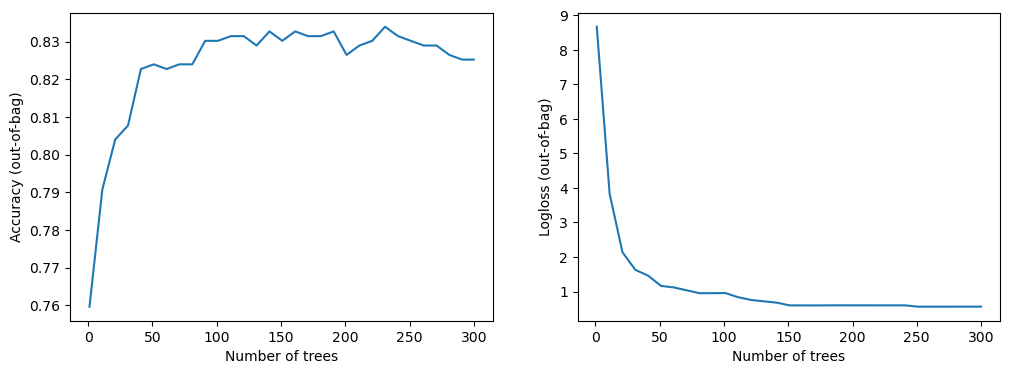

In [197]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [198]:
# This cell start TensorBoard that can be slow.
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Google internal version
# %load_ext google3.learning.brain.tensorboard.notebook.extension

In [201]:
# Clear existing results (if any)
rm -fr "/tmp/tensorboard_logs"

SyntaxError: invalid syntax (<ipython-input-201-070c4d4e4a96>, line 2)

In [200]:
# Export the meta-data to tensorboard.
model_1.make_inspector().export_to_tensorboard("/tmp/tensorboard_logs")

In [202]:
# Start a tensorboard instance.
%tensorboard --logdir "/tmp/tensorboard_logs"

In [113]:
# ? tfdf.keras.GradientBoostedTreesModel

# Test New Model

In [203]:
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,label
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


In [217]:
feature_1 = tfdf.keras.FeatureUsage(name="Sex")
feature_2 = tfdf.keras.FeatureUsage(name="Pclass")
feature_3 = tfdf.keras.FeatureUsage(name="Age")
feature_4 = tfdf.keras.FeatureUsage(name="Parch")
feature_5 = tfdf.keras.FeatureUsage(name="SibSp")
feature_6 = tfdf.keras.FeatureUsage(name="Embarked")
feature_7 = tfdf.keras.FeatureUsage(name="Fare")

all_features = [feature_1, feature_2,feature_3]

# Note: This model is only trained with two features. It will not be as good as
# the one trained on all features.

model_2 = tfdf.keras.GradientBoostedTreesModel(features=all_features, exclude_non_specified_features=True)

model_2.compile(metrics=["accuracy"])
model_2.fit(x=train_ds, validation_data=test_ds)

print(model_2.evaluate(test_ds, return_dict=True))

2/2 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.8000
{'loss': 0.0, 'accuracy': 0.800000011920929}


# Define Data Semantics

In [222]:
feature_1 = tfdf.keras.FeatureUsage(name="Pclass", semantic=tfdf.keras.FeatureSemantic.CATEGORICAL)
feature_2 = tfdf.keras.FeatureUsage(name="Sex")
feature_3 = tfdf.keras.FeatureUsage(name="Age")
all_features = [feature_1, feature_2, feature_3]

model_3 = tfdf.keras.GradientBoostedTreesModel(features=all_features, exclude_non_specified_features=True)
model_3.compile( metrics=["accuracy"])
model_3.fit(x=train_ds, validation_data=test_ds)

13/13 [==============================] - 0s 15ms/step - val_loss: 0.0000e+00 - val_accuracy: 0.8222


# Hyper-parameters

In [234]:
# A classical but slighly more complex model.
model_6 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500, growing_strategy="BEST_FIRST_GLOBAL", max_depth=8)
model_6.compile( metrics=["accuracy"])
model_6.fit(x=train_ds)
print(model_6.evaluate(test_ds, return_dict=True))

2/2 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.7667
{'loss': 0.0, 'accuracy': 0.7666666507720947}


In [235]:
# A more complex, but possibly, more accurate model.
model_7 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500,
    growing_strategy="BEST_FIRST_GLOBAL",
    max_depth=8,
    split_axis="SPARSE_OBLIQUE",
    categorical_algorithm="RANDOM",
    )
model_7.compile( metrics=["accuracy"])
model_7.fit(x=train_ds, validation_data=test_ds)
print(model_7.evaluate(test_ds, return_dict=True))

2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.8111
{'loss': 0.0, 'accuracy': 0.8111110925674438}


In [236]:
# A good template of hyper-parameters.
model_8 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
model_8.compile( metrics=["accuracy"])
model_8.fit(x=train_ds, validation_data=test_ds)
print(model_8.evaluate(test_ds, return_dict=True))

2/2 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.7778
{'loss': 0.0, 'accuracy': 0.7777777910232544}


In [237]:
# The hyper-parameter templates of the Gradient Boosted Tree model.
print(tfdf.keras.GradientBoostedTreesModel.predefined_hyperparameters())

[HyperParameterTemplate(name='better_default', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL'}, description='A configuration that is generally better than the default parameters without being more expensive.'), HyperParameterTemplate(name='benchmark_rank1', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')]


In [238]:
# Feature Preprocessing

# Pre Processing
With kera to embed  processing into model

In [267]:
fare_dollars = tf.keras.layers.Input(shape=(1,), name="Fare")
fare_cents = fare_dollars * 100.0

age_years = tf.keras.layers.Input(shape=(1,), name="Age")

raw_inputs = {"Fare": fare_dollars, "Age": age_years}
processed_inputs = {"Fare_cents": fare_cents, "Age": age_years}

# "preprocessor" contains the preprocessing logic.
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

# "model_4" contains both the pre-processing logic and the decision forest.
model_4 = tfdf.keras.RandomForestModel(preprocessing=preprocessor)
model_4.fit(x=train_ds)

#model_4.summary()

13/13 [==============================] - 0s 882us/step
